In [516]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels as sm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 
from sklearn import metrics
from sklearn.metrics import r2_score
from scipy import stats
from scipy.special import boxcox, inv_boxcox

In [517]:
df_fuel = pd.read_csv('auto-mpg.csv')
df_fuel.head()


,mpg,cyl,disp,hp,weight,acceleration,year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [518]:
df_fuel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cyl           398 non-null    int64  
 2   disp          398 non-null    float64
 3   hp            398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   year          398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [519]:
df_fuel.shape

(398, 9)

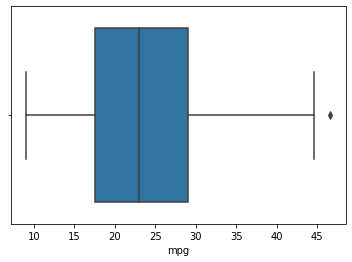

In [520]:
sns.boxplot(data = df_fuel,x=df_fuel['mpg'])

In [521]:
Q1 = df_fuel['mpg'].quantile(0.25)
Q3 = df_fuel['mpg'].quantile(0.75)
IQR = Q3-Q1
print(Q1)
print(Q3)
print(IQR)
Lower_Whisker = Q1 - 1.5*IQR
Upper_Whisker = Q3 + 1.5*IQR
print(Lower_Whisker, Upper_Whisker)

17.5
29.0
11.5
0.25 46.25


In [522]:
df_fuel = df_fuel[df_fuel['mpg']< Upper_Whisker]
df_fuel.shape

(397, 9)

In [523]:
origin = df_fuel.pop('origin')

In [524]:
#one-hot encoding
df_fuel['US'] = (origin == 1)* 1.0
df_fuel['Korea'] = (origin == 2)* 1.0
df_fuel['Japan'] = (origin == 3)* 1.0
df_fuel.tail()

,mpg,cyl,disp,hp,weight,acceleration,year,car name,US,Korea,Japan
393,27.0,4,140.0,86,2790,15.6,82,ford mustang gl,1.0,0.0,0.0
394,44.0,4,97.0,52,2130,24.6,82,vw pickup,0.0,1.0,0.0
395,32.0,4,135.0,84,2295,11.6,82,dodge rampage,1.0,0.0,0.0
396,28.0,4,120.0,79,2625,18.6,82,ford ranger,1.0,0.0,0.0
397,31.0,4,119.0,82,2720,19.4,82,chevy s-10,1.0,0.0,0.0


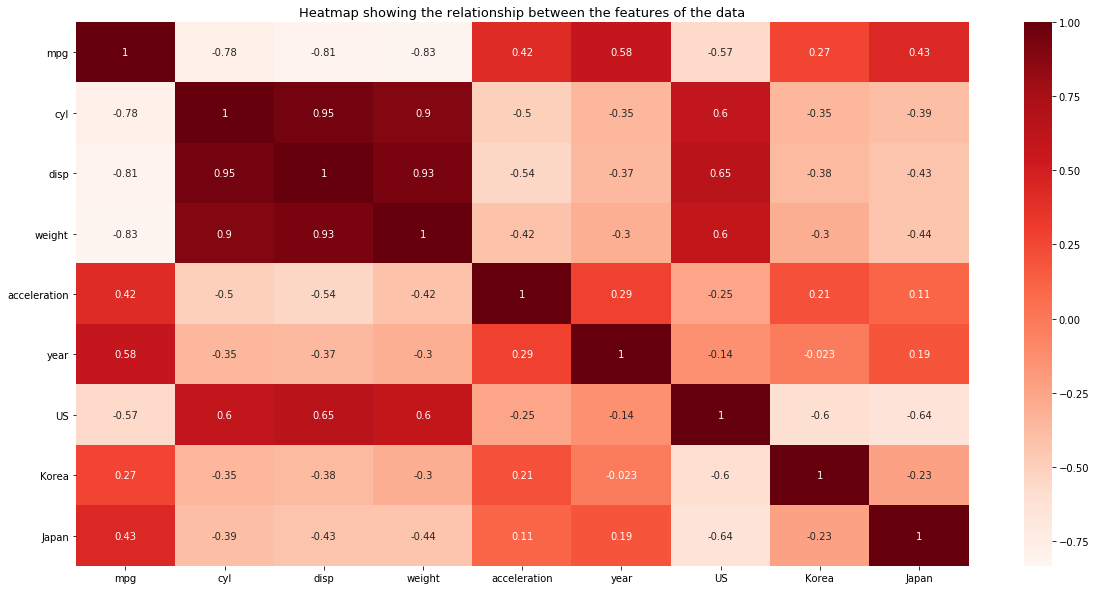

In [525]:
plt.figure(figsize=(20,10))
sns.heatmap(df_fuel.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap showing the relationship between the features of the data',
         fontsize=13)
plt.show()

In [526]:
print('Correlation between mpg and the remaining variables:\n\n{}'.format(df_fuel.corr().mpg))

Correlation between mpg and the remaining variables:

mpg             1.000000
cyl            -0.778350
disp           -0.806521
weight         -0.834482
acceleration    0.418997
year            0.578468
US             -0.566010
Korea           0.265474
Japan           0.434204
Name: mpg, dtype: float64


In [527]:
df_fuel = df_fuel._get_numeric_data() #This line will drop non-numeric cols
df_fuel.head()

,mpg,cyl,disp,weight,acceleration,year,US,Korea,Japan
0,18.0,8,307.0,3504,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,3693,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,3436,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,3433,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,3449,10.5,70,1.0,0.0,0.0


In [528]:
vif = pd.DataFrame()
vif["variables"] = df_fuel.columns
vif["VIF"] = [variance_inflation_factor(df_fuel.values, i) for i in range(df_fuel.shape[1])]
print(vif)

      variables         VIF
0           mpg    5.802936
1           cyl   10.568842
2          disp   21.446342
3        weight   12.420618
4  acceleration    1.637226
5          year    2.056814
6            US  416.823382
7         Korea  109.275436
8         Japan  125.125242


In [529]:
df_fuel = df_fuel.drop(['disp','cyl'], axis = 1)

In [530]:
vif = pd.DataFrame()
vif["variables"] = df_fuel.columns
vif["VIF"] = [variance_inflation_factor(df_fuel.values, i) for i in range(df_fuel.shape[1])]
print(vif)

      variables         VIF
0           mpg    5.663866
1        weight    4.177136
2  acceleration    1.277168
3          year    1.904663
4            US  377.354076
5         Korea  101.124058
6         Japan  114.926322


,weight,acceleration,year,US,Korea,Japan,newmpg
0,3504,12.0,70,1.0,0.0,0.0,6.485281
1,3693,11.5,70,1.0,0.0,0.0,5.745967
2,3436,11.0,70,1.0,0.0,0.0,6.485281
3,3433,12.0,70,1.0,0.0,0.0,6.000000
4,3449,10.5,70,1.0,0.0,0.0,6.246211


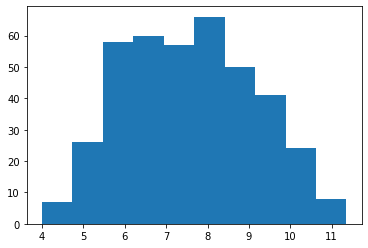

In [531]:
df_fuel['newmpg']= stats.boxcox(df_fuel['mpg'],lmbda=0.5)
plt.hist(df_fuel.newmpg)
df_fuel=df_fuel.drop(['mpg'],axis=1)
df_fuel.head()

In [532]:
x = df_fuel.drop('newmpg',axis=1) # DataFrame of only independent variables
y = df_fuel.newmpg   # create a series of the target variable
# split our data into training and testing data
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=.2,random_state=0)

In [533]:
model = LinearRegression()
model.fit(X_train, y_train)
print(model.intercept_)

-0.6956253823746463


In [534]:
print(model.coef_)

[-0.00127263  0.02282069  0.15490833 -0.2322997   0.16209737  0.07020233]


In [535]:
y_pred = model.predict(X_test)

In [536]:
R2=model.score(X_test,y_test)
R2

0.8684568412630583

In [537]:
#Training hitrate
print('Train rate: {}\n'.format(model.score(X_train,y_train)))
# Test hitrate
print('Test rate: {}\n'.format(model.score(X_test,y_test)))
# Model Accuracy
print('Model Accuracy: {}\n'.format(r2_score(y_test,y_pred)))

Train rate: 0.8537278901302239

Test rate: 0.8684568412630583

Model Accuracy: 0.8684568412630583



In [538]:
y_newpred=inv_boxcox(y_pred, 0.5)
y_newtest=inv_boxcox(y_test,0.5)

In [539]:
def mape(y_test, y_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

mape(y_test, y_pred)

6.181816286708177

In [540]:
df = pd.DataFrame({'Actual': y_newtest, 'Predicted': y_newpred})
df

,Actual,Predicted
65,14.0,13.204031
132,25.0,23.465438
74,13.0,12.694788
78,21.0,21.500480
37,18.0,16.973957
...,...,...
268,27.2,29.516679
234,24.5,24.394471
145,32.0,28.742018
164,21.0,20.999303


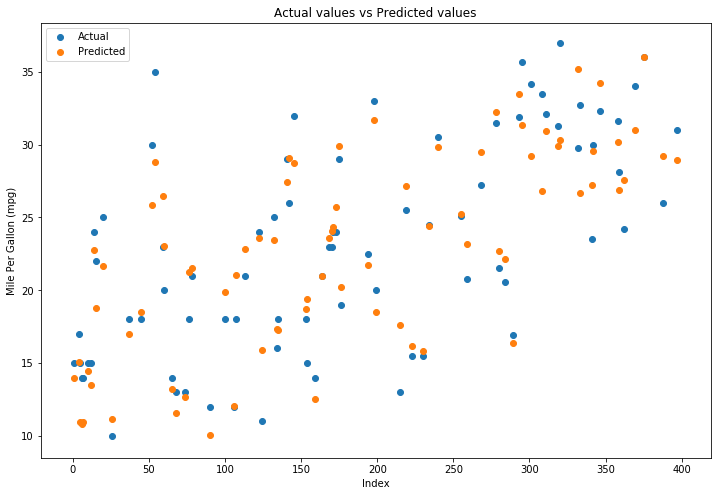

In [541]:
plt.figure(figsize=(12,8))
plt.scatter(df.index,df['Actual'].values,label='Actual')
plt.scatter(df.index,df['Predicted'].values,label='Predicted')
plt.title('Actual values vs Predicted values')
plt.xlabel('Index')
plt.ylabel('Miles Per Gallon (mpg)')
plt.legend(loc='upper left')
plt.show()